In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [2]:
init_notebook_mode(connected=True)

In [3]:
# pair_df = services_24[['nren', 'service_name']].drop_duplicates()
# pairs_list = list(pair_df.itertuples(index=False, name=None))

In [4]:
def create_sankey(service_matrix):

    label_list = list(pd.concat(
        [service_matrix["nren"], service_matrix["service_name"]]
    ).unique())
    
    # Create index mappings
    label_to_index = {label: i for i, label in enumerate(label_list)}
    
    nren_name_indexes = service_matrix['nren'].map(label_to_index).tolist()
    service_name_indexes = service_matrix['service_name'].map(label_to_index).tolist()
    values = [1] * len(service_matrix)

    return go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=label_list
        ),
        link=dict(
            source=nren_name_indexes,     # Indexes of nren name labels
            target=service_name_indexes,  # Indexes of service name labels
            value=values                  # Flow values
        )
    ))

In [5]:
YEAR=2024
full_service_matrix = pd.read_excel('compendium.xlsx', sheet_name='Services')
year_service_matrix = full_service_matrix[full_service_matrix['year'] == YEAR]

In [6]:
import dash
from jupyter_dash import JupyterDash

app = dash.Dash()

app.layout = dash.html.Div([
    dash.html.H2('service matrix'),

    dash.dcc.Dropdown(
        id='nren-dropdown',
        options=[
            {'label': n, 'value': n} for n in year_service_matrix['nren'].unique()
        ],
        placeholder='select nren filters ...',
        multi=True,
    ),

    dash.dcc.Dropdown(
        id='service-dropdown',
        options=[
            {'label': n, 'value': n} for n in year_service_matrix['service_name'].unique()
        ],
        placeholder='select service name filters ...',
        multi=True,
    ),

    dash.dcc.Graph(id='service-matrix-sankey'),
])

@app.callback(
    dash.Output('service-matrix-sankey', 'figure'),
    [
        dash.Input('nren-dropdown', 'value'),
        dash.Input('service-dropdown', 'value'),
    ]
)
def update_sankey(selected_nrens, selected_services):
    _sm_df = year_service_matrix
    if selected_nrens:
        _sm_df = _sm_df[_sm_df['nren'].isin(selected_nrens)]
    if selected_services:
        _sm_df = _sm_df[_sm_df['service_name'].isin(selected_services)]
    return create_sankey(_sm_df)

app.run_server(mode='inline')

# snapshot

In [7]:
_year = 2024
_nrens = ['ARNES', 'SURF']
_services = ['Mailing lists', 'DNS hosting',
            'eduroam', 'FileSender',
            'Domain name registration', 'Interfederation',
            'IP address allocation/LIR', 'IP Connectivity',
            'DDos mitigation', 'Firewall-On-Demand',
           ]
_snapshot_df = full_service_matrix[full_service_matrix['year'] == _year]
_snapshot_df = _snapshot_df[_snapshot_df['nren'].isin(_nrens)]
_snapshot_df = _snapshot_df[_snapshot_df['service_name'].isin(_services)]

fig = create_sankey(_snapshot_df)
fig.update_layout(title_text='Service Matrix', font_size=12)
# fig.show()
fig.write_image('sm-snapshot.png')

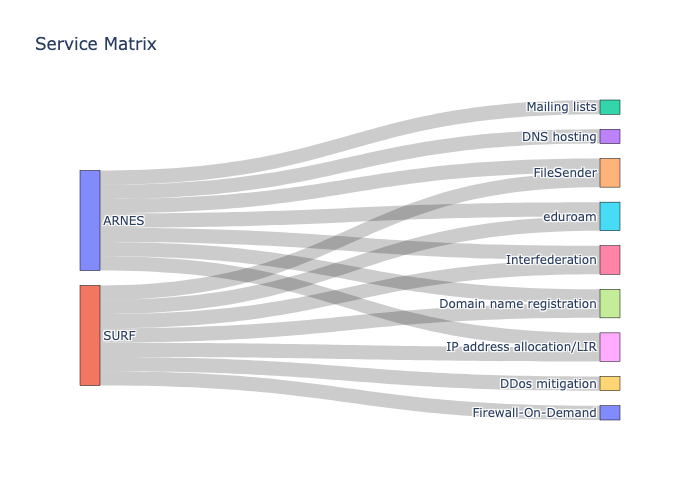

In [21]:
import IPython.display as display
display.Image('sm-snapshot.png')